In [4]:
import pandas as pd
from datetime import datetime
pd.set_option('display.max_columns', 500)

#1 FATTO
#2 FATTO
#3 FATTO
#4 FATTO
#5 FATTO
#6 FATTO
#7 FATTO
#8 FATTO
#9 FATTO
#10 NN
#11 NN
#12 FATTO

# 1) Normalize the loan_lenders table. In the normalized table, each row must have one loan_id and one lender.


Il metodo per farlo normalmente sarebbe utilizzando una serie di funzioni pandas come mostrato di seguito

In [6]:
loans_lenders= pd.read_csv("dataset/loans_lenders.csv")
loans_lenders_norm = loans_lenders.lenders.str.split(',').apply(pd.Series)           
loans_lenders_norm.index = loans_lenders.loan_id                                
loans_lenders_norm = loans_lenders_norm.stack().reset_index('loan_id') 

# Oppure

loans_lenders_norm = pd.DataFrame(loans_lenders.lenders.str.split(',').tolist(), index=loans_lenders.loan_id).stack()
loans_lenders_norm = loans_lenders_norm.reset_index([0, 'loan_id'])
loans_lenders_norm.columns = ['loan_id', 'lenders']

Il problema è che il dataset risultante da entrambe le funzioni risulta troppo grosso per la RAM disponibile e quindi restituisce un Memory Error, per aggirare questo ostacolo si procede quindi a lavorare su chunk più piccoli per poi unirli tutti assieme in seguito.

Il prodotto è una Serie, lo converto quindi in DataFrame.
Da notare che alcuni lender_name presentano degli spazi alle estremitità, questo compromette la loro identificazione, per questo viene effettuato uno strip

In [10]:
def prepro(chunk_x):
    new_df = pd.DataFrame(chunk_x.lenders.str.split(',').tolist(), index=chunk_x.loan_id).stack()
    return new_df

In [11]:
loans_lenders = pd.read_csv(r'dataset/loans_lenders.csv', chunksize=1000)

chunk_list = [] 
for chunk in loans_lenders:  
    chunk_filter = prepro(chunk)
    chunk_list.append(chunk_filter)
    
# Concatenazione dei chunk
loans_lenders_norm = pd.concat(chunk_list)
loans_lenders_norm.reset_index([0, 'loan_id'])
loans_lenders_norm.columns = ['loan_id', 'lenders']
loans_lenders_norm=loans_lenders_norm.to_frame().reset_index().drop(['level_1'], axis=1).rename(columns={0: "lender_name"})
loans_lenders_norm['lender_name']=loans_lenders_norm['lender_name'].str.strip()
loans_lenders_norm.head()

,loan_id,lender_name
0,483693,muc888
1,483693,sam4326
2,483693,camaran3922
3,483693,lachheb1865
4,483693,rebecca3499


In [12]:
######## DA CANCELLARE IN SEGUITO, SERVE SOLO PER NON RIESEGUIRE SEMPRE LA FUNZIONE SOPRA
loans_lenders_norm.to_csv("dataset/loans_lenders_norm.csv",index=True,header=True)


In [5]:
######## DA CANCELLARE IN SEGUITO, SERVE SOLO PER NON RIESEGUIRE SEMPRE LA FUNZIONE SOPRA
loans_lenders_norm= pd.read_csv("dataset/loans_lenders_norm.csv")
#loans_lenders_norm=loans_lenders_norm.rename(columns={"0": "lender_name"})
loans_lenders_norm=loans_lenders_norm.drop(['Unnamed: 0'], axis=1)
loans_lenders_norm

,loan_id,lender_name
0,483693,muc888
1,483693,sam4326
2,483693,camaran3922
3,483693,lachheb1865
4,483693,rebecca3499
...,...,...
28293926,1206425,trogdorfamily7622
28293927,1206425,danny6470
28293928,1206425,don6118
28293929,1206486,alan5175


# 2) For each loan, add a column duration corresponding to the number of days between the disburse time and the planned expiration time.


In [6]:
# 2) For each loan, add a column duration corresponding to the number of days between the disburse time and the planned expiration time.
loans=pd.read_csv("dataset/loans.csv")
test=loans  # Andrà rimosso, è fatto per non calcolare una tabella gigante
test = test.dropna(subset=['planned_expiration_time'])
test = test.dropna(subset=['disburse_time'])
test=test.reset_index(drop=True)
# Giorni di differenza 
FMT="%Y-%m-%d %H:%M:%S.%f %z"
test['duration']=(test['planned_expiration_time'].apply(lambda x: datetime.strptime(x, FMT)) - test['disburse_time'].apply(lambda x: datetime.strptime(x, FMT))).apply(lambda x:x.days)
test.head()

,loan_id,loan_name,original_language,description,description_translated,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,currency_policy,currency_exchange_coverage_rate,currency,partner_id,posted_time,planned_expiration_time,disburse_time,raised_time,lender_term,num_lenders_total,num_journal_entries,num_bulk_entries,tags,borrower_genders,borrower_pictured,repayment_interval,distribution_model,duration
0,657307,Aivy,English,"Aivy, 21 years of age, is single and lives in ...",NaN,125.0,125.0,funded,General Store,Retail,to buy additional inventories for her sari-sa...,PH,Philippines,Ozamiz - Ozamiz City,shared,0.1,PHP,126.0,2014-01-15 02:23:45.000 +0000,2014-02-14 03:30:06.000 +0000,2013-12-22 08:00:00.000 +0000,2014-01-15 04:48:22.000 +0000,7.0,3,2,1,NaN,female,true,irregular,field_partner,53
1,657259,Idalia Marizza,Spanish,"Doña Idalia, esta casada, tiene 57 años de eda...","Idalia, 57, is married and lives with her husb...",400.0,400.0,funded,Used Clothing,Clothing,"To buy American clothing such as blouses, shir...",HN,Honduras,"La Lopez, Choloma",shared,0.1,HNL,201.0,2014-01-14 20:23:20.000 +0000,2014-03-26 22:25:07.000 +0000,2013-12-20 08:00:00.000 +0000,2014-02-25 06:42:06.000 +0000,8.0,11,2,1,NaN,female,true,monthly,field_partner,96
2,658010,Aasia,English,Aasia is a 45-year-old married lady and she ha...,NaN,400.0,400.0,funded,General Store,Retail,"to buy stock of rice, sugar and flour",PK,Pakistan,Lala Musa,shared,0.1,PKR,245.0,2014-01-16 11:32:58.000 +0000,2014-02-15 21:10:05.000 +0000,2014-01-09 08:00:00.000 +0000,2014-01-24 23:06:18.000 +0000,14.0,16,2,1,"#Woman Owned Biz, #Supporting Family, user_fav...",female,true,monthly,field_partner,37
3,659347,Gulmira,Russian,"Гулмире 36 лет, замужем, вместе с супругом вос...",Gulmira is 36 years old and married. She and ...,625.0,625.0,funded,Farming,Agriculture,"to buy cucumber and tomato seeds, as well as f...",KG,Kyrgyzstan,"Aravan village, Osh region",shared,0.1,KGS,171.0,2014-01-20 09:59:48.000 +0000,2014-02-21 03:10:02.000 +0000,2014-01-17 08:00:00.000 +0000,2014-01-22 05:29:28.000 +0000,14.0,21,2,1,user_favorite,female,true,monthly,field_partner,34
4,656933,Ricky\t,English,Ricky is a farmer who currently cultivates his...,NaN,425.0,425.0,funded,Farming,Agriculture,to buy organic fertilizer and agrochemical pr...,PH,Philippines,"Baleleng, Sto. Thomas, Isabela",shared,0.1,PHP,123.0,2014-01-14 05:46:21.000 +0000,2014-02-13 06:10:02.000 +0000,2013-12-17 08:00:00.000 +0000,2014-01-14 17:29:27.000 +0000,7.0,15,2,1,"#Animals, #Eco-friendly, #Sustainable Ag",male,true,bullet,field_partner,57


In [13]:
test.loc[test['loan_id']==551251] # Da cancellare

,loan_id,loan_name,original_language,description,description_translated,funded_amount,loan_amount,status,activity_name,sector_name,...,lender_term,num_lenders_total,num_journal_entries,num_bulk_entries,tags,borrower_genders,borrower_pictured,repayment_interval,distribution_model,duration


# 3) Find the lenders that have funded at least twice.



In [14]:
#3)Find the borrowers that have funded at least twice.
lender_mult=((loans_lenders_norm.groupby("lender_name").count())>1) # Cerco i lender che hanno donato più di una volta
(lender_mult.loc[lender_mult['loan_id']]).drop(['loan_id'], axis=1) # stampo quelli uguali a True e elimino la colonna



""
lender_name
000
00000
0002
0101craign0101
0132575
0154884
0161130
0169713
0185429


# 4)For each country, compute how many loans have involved that country as borrowers.


In [103]:
#4)For each country, compute how many loans have involved that country as borrowers.
test2.country_name.value_counts()

Philippines                         2487
Kenya                                992
El Salvador                          563
Peru                                 445
Cambodia                             443
Nicaragua                            307
Uganda                               289
Pakistan                             283
Tajikistan                           283
India                                278
Ecuador                              228
Colombia                             216
Paraguay                             207
Bolivia                              173
Jordan                               133
Liberia                              132
Sierra Leone                         132
Honduras                             128
Vietnam                              124
Rwanda                               120
Ghana                                120
Samoa                                109
Lebanon                               98
Armenia                               98
Mexico          

# 5)For each country, compute the overall amount of money borrowed.


In [110]:
#5)For each country, compute the overall amount of money borrowed.
test2.groupby('country_name').sum().funded_amount

country_name
Afghanistan                               1175.0
Albania                                  39050.0
Armenia                                 152150.0
Azerbaijan                              103300.0
Belize                                    1250.0
Benin                                    37525.0
Bolivia                                 294875.0
Burkina Faso                             21950.0
Burundi                                  78225.0
Cambodia                                319200.0
Cameroon                                 14450.0
Chile                                    24225.0
China                                     3100.0
Colombia                                147475.0
Congo                                    18450.0
Costa Rica                               33375.0
Dominican Republic                       43500.0
Ecuador                                 253450.0
Egypt                                     9375.0
El Salvador                             335050.0
Georgia

# 6) Like the previous point, but expressed as a percentage of the overall amount lent.


In [167]:
#6) Like the previous point, but expressed as a percentage of the overall amount lent.
(test2.groupby('country_name').sum()).apply(lambda x:100 * x / float(x.sum())).funded_amount

country_name
Afghanistan                              0.014365
Albania                                  0.477400
Armenia                                  1.860087
Azerbaijan                               1.262879
Belize                                   0.015282
Benin                                    0.458756
Bolivia                                  3.604950
Burkina Faso                             0.268346
Burundi                                  0.956328
Cambodia                                 3.902332
Cameroon                                 0.176656
Chile                                    0.296159
China                                    0.037899
Colombia                                 1.802933
Congo                                    0.225558
Costa Rica                               0.408021
Dominican Republic                       0.531803
Ecuador                                  3.098515
Egypt                                    0.114613
El Salvador                          

# 7) Like the three previous points, but split for each year (with respect to disburse time).

### 7-4)For each country, compute how many loans have involved that country as borrowers.

In [208]:
#7)Like the three previous points, but split for each year (with respect to disburse time).   
#test2['disburse_time_year']=(test2['disburse_time'].apply(lambda x: datetime.strptime(x, FMT).year))  # Questa poi si puo cancellare
FMT="%Y-%m-%d %H:%M:%S.%f %z"

    #7-4)For each country, compute how many loans have involved that country as borrowers.
#test2.groupby(["country_name","disburse_time_year"]).count().loan_id

print(test2.groupby(["country_name",(test2['disburse_time'].apply(lambda x: datetime.strptime(x, FMT).year))]).count().loan_id)





country_name   disburse_time
Afghanistan    2010              1
Albania        2012              5
               2013             13
               2014              7
               2015              2
               2016              3
Armenia        2010              1
               2012             16
               2013             42
               2014             13
               2015             12
               2016              9
               2017              5
Azerbaijan     2010              2
               2012             14
               2013             25
               2014              8
               2015              9
Belize         2013              1
               2014              1
Benin          2010              2
               2012             26
               2013             10
               2014              8
Bolivia        2010             14
               2012             35
               2013             73
               2014       

### 7-5) For each country, compute the overall amount of money borrowed.

In [209]:
    #7-5)For each country, compute the overall amount of money borrowed.
test2.groupby(['country_name',(test2['disburse_time'].apply(lambda x: datetime.strptime(x, FMT).year))]).sum().funded_amount


country_name   disburse_time
Afghanistan    2010               1175.0
Albania        2012               4250.0
               2013              14775.0
               2014              13475.0
               2015               2025.0
               2016               4525.0
Armenia        2010               3000.0
               2012              23150.0
               2013              73800.0
               2014              22425.0
               2015              13000.0
               2016              12350.0
               2017               4425.0
Azerbaijan     2010               5050.0
               2012              21600.0
               2013              47900.0
               2014              17075.0
               2015              11675.0
Belize         2013                500.0
               2014                750.0
Benin          2010                900.0
               2012              18500.0
               2013              10000.0
               2014         

### 7-6) Like the previous point, but expressed as a percentage of the overall amount lent.


In [210]:
    #7-6) Like the previous point, but expressed as a percentage of the overall amount lent.
(test2.groupby(['country_name',(test2['disburse_time'].apply(lambda x: datetime.strptime(x, FMT).year))]).sum()).apply(lambda x:100 * x / float(x.sum())).funded_amount

country_name   disburse_time
Afghanistan    2010             0.014365
Albania        2012             0.051958
               2013             0.180630
               2014             0.164737
               2015             0.024756
               2016             0.055320
Armenia        2010             0.036676
               2012             0.283017
               2013             0.902231
               2014             0.274153
               2015             0.158930
               2016             0.150983
               2017             0.054097
Azerbaijan     2010             0.061738
               2012             0.264068
               2013             0.585594
               2014             0.208748
               2015             0.142731
Belize         2013             0.006113
               2014             0.009169
Benin          2010             0.011003
               2012             0.226169
               2013             0.122253
               2014         

### 7-6*) Like the previous point, but expressed as a percentage of the overall amount lent. Year percentage of total found requested per country


In [211]:
#7-6*) Like the previous point, but expressed as a percentage of the overall amount lent. Year percentage of total found requested per country
(test2.groupby(['country_name',(test2['disburse_time'].apply(lambda x: datetime.strptime(x, FMT).year))]).sum()).groupby(level=0).apply(lambda x:100 * x / (x.sum())).funded_amount

country_name   disburse_time
Afghanistan    2010             100.000000
Albania        2012              10.883483
               2013              37.836108
               2014              34.507042
               2015               5.185659
               2016              11.587708
Armenia        2010               1.971738
               2012              15.215248
               2013              48.504765
               2014              14.738745
               2015               8.544200
               2016               8.116990
               2017               2.908314
Azerbaijan     2010               4.888674
               2012              20.909971
               2013              46.369797
               2014              16.529526
               2015              11.302033
Belize         2013              40.000000
               2014              60.000000
Benin          2010               2.398401
               2012              49.300466
               2013      

# 8) For each lender, compute the overall amount of money lent.


Creo una variabile list_unique in cui è presente il nome di ogni lender preso una sola volta

In [26]:
list_unique=(loans_lenders_norm.lender_name.unique()) # Restituisce un unico nome per lender

Creo un dataframe lender_loans_tot in cui vado ad inserire in seguito il nome del lender e il totale prestato

In [28]:
lender_loans_tot = pd.DataFrame(columns=["lender_name","total_lend"])

Estraggo i dati necessari ciclando per tutti i nomi nella lista dei donatori univoci, e in seguito per ogni donazione effettuata dall'utente

In [29]:
for x in range(len(list_unique)): # Qua ciclo per tutta la lista dei donatori univoci
    count=0
    lista_don=(loans_lenders_norm.loc[loans_lenders_norm["lender_name"]==list_unique[x]]).reset_index() # tutti prestiti effettuati da un donatore
    for y in range(len(lista_don)):
        count+=(int(loans.loc[loans['loan_id']==lista_don["loan_id"][y],["funded_amount"]].values)/int(loans.loc[loans['loan_id']==lista_don["loan_id"][y],["num_lenders_total"]].values))
    
    lender_loans_tot.loc[len(lender_loans_tot)] = [lista_don["lender_name"][0], count]
     

Mostro i primi 20 risultati

In [37]:
pd.set_option('display.float_format', lambda x: '%.3f' % x) # Tolgo notazione scientifica
(lender_loans_tot[0:20])

,lender_name,total_lend
0,muc888,29841.007
1,sam4326,22067.557
2,camaran3922,1535.904
3,lachheb1865,27.841
4,rebecca3499,499196.012
5,karlheinz4543,33010.007
6,jerrydb,9888.385
7,paula8951,3501.078
8,gmct,5096453.784
9,amra9383,290.597


Come si può vedere ci sono degli utenti con valori molto elevati, si va quindi a controllare se sono associati veramente ad un numero elevato di prestiti <br>
Utenti: "rebecca3499" "gmct"

In [38]:
(loans_lenders_norm.loc[loans_lenders_norm["lender_name"]=="rebecca3499"])

,loan_id,lender_name
4,483693,rebecca3499
1659,290375,rebecca3499
3532,356152,rebecca3499
3572,449992,rebecca3499
3573,449992,rebecca3499
8493,1254436,rebecca3499
11118,310950,rebecca3499
21436,309220,rebecca3499
21477,511600,rebecca3499
23681,864967,rebecca3499


In [39]:
(loans_lenders_norm.loc[loans_lenders_norm["lender_name"]=="gmct"])

,loan_id,lender_name
8,483693,gmct
4745,464216,gmct
4977,490846,gmct
5291,575610,gmct
5292,575610,gmct
5293,575610,gmct
5404,492469,gmct
6900,517220,gmct
7322,454987,gmct
9628,463702,gmct


Questo dimostra che non sembrano esserci problemi di programmazione in quanto l'utente "rebecca3499" ha effettuato 14995 prestiti mentre "gmct" ne ha effettuati 128159, ottenendo una donazione media di 33 \\$ e 39.7 \\$ rispettivamente.
Risulta però questionabile l'attendibilità del dataset, come spiegato anche nell'appendice in fondo vi sono anche delle discrepanze tra il numero di lender registrati tra le tabelle loans_lenders e loans. Inoltre lo stesso nome compare più volte nello stesso prestito, non è chiaro se rappresenta un errore del dataset o è voluto.

# 8-1) Modifica alternativa

Il metodo precedentemente descritto benchè funzionante risulta estremamente lento da calcolare, per ovviare a questo viene qui presentato un metodo alternativo molto più rapido del precendete.<br>
Qui invece di calcolare sulla lista già esplosa il calcolo viene effettuato sul DF originale per scompattarlo in seguito, inoltre viene iutilizzato il ciclo itertuples che è molto più rapido

In [ ]:
for row in loans_lenders.itertuples(index=True):
    try:
        obj_lend=loans.loc[loans.loan_id==row.loan_id]
        loans_lenders.set_value(row.Index, 'loan_imp', obj_lend['imp_div'])
    except:
        pass
loans_lenders.to_csv("dataset/loans_lenders_import.csv",index=True,header=True)

In [ ]:
loans_lenders = pd.read_csv(r'dataset/loans_lenders_import.csv', chunksize=2000)
chunk_list = [] 
for chunk in loans_lenders:  
    chunk_filter = pre(chunk)
    chunk_list.append(chunk_filter)
    
# Concatenazione dei chunk
loans_lenders_norm_imp = pd.concat(chunk_list)
loans_lenders_norm=loans_lenders_norm.drop(['Unnamed: 0'], axis=1)
loans_lenders_norm.columns = ['loan_id','loan_imp', 'lenders']
loans_lenders_norm.to_csv("dataset/loans_lenders_imp_norm.csv",index=True,header=True)


In [7]:
loans_lenders_norm_imp = pd.read_csv(r'dataset/loans_lenders_imp_norm.csv')


In [8]:
loans_lenders_norm_imp.head()

,Unnamed: 0,loan_id,loan_imp,lenders
0,0,483693,27,muc888
1,1,483693,27,sam4326
2,2,483693,27,camaran3922
3,3,483693,27,lachheb1865
4,4,483693,27,rebecca3499


In [9]:
loans_lenders_tot=loans_lenders_norm_imp.groupby('lenders').sum()

In [10]:
loans_lenders_tot=loans_lenders_tot.reset_index()

In [11]:
loans_lenders_tot=loans_lenders_tot.drop(['Unnamed: 0','loan_id'], axis=1)


In [12]:
loans_lenders_tot

,lenders,loan_imp
0,000,1494
1,00000,1234
2,0002,2179
3,00mike00,38
4,0101craign0101,2392
...,...,...
1383794,zzmcfate,56758
1383795,zzpaghetti9994,44
1383796,zzrvmf8538,475
1383797,zzzsai,235


# 9) For each country, compute the difference between the overall amount of money lent and the overall amount of money borrowed. Since the country of the lender is often unknown, you can assume that the true distribution among the countries is the same as the one computed from the rows where the country is known.

In [13]:
lender_detail=pd.read_csv("dataset/lenders.csv")

In [14]:
columns=['country_code','distrib','distrib_perc']

Creo un nuovo DataFrame che conterrà i dati relativi ad ogni country

In [15]:
country_df = pd.DataFrame(columns=columns)

In [16]:
z=(lender_detail.country_code.unique())[1:]

In [17]:
for ele in z:
    country_df.loc[len(country_df)] = [ele, 0, 0 ]
    

In [18]:
country_df.head()

,country_code,distrib,distrib_perc
0,US,0,0
1,IN,0,0
2,AU,0,0
3,PL,0,0
4,BR,0,0


In [19]:
# Utenti SENZA country code
lender_detail.isna().sum()['country_code']

1458635

In [20]:
# Utenti CON country code
tot_country_pres=lender_detail.count()['country_code']
print(tot_country_pres)

890539


In [21]:
#Totale utenti
tot_all=lender_detail.isna().sum()['country_code']+lender_detail.count()['country_code']
print(tot_all)

2349174


Conta quanti utenti ci sono per ogni country

In [22]:
country_popularity=lender_detail.groupby("country_code").count().reset_index()

Calcolo la distribuzione di ogni country rispetto al totale

In [23]:
# Inserisco la percentuale del country rispetto al totale degli utenti con country presente
for x in range(len(country_df)):
    country_df['distrib'][x]=int(country_popularity.loc[country_popularity['country_code']==country_df['country_code'][x]]['permanent_name'].values)
    country_df['distrib_perc'][x]=int(country_popularity.loc[country_popularity['country_code']==country_df['country_code'][x]]['permanent_name'].values)/tot_country_pres

In [24]:
country_df.head()

,country_code,distrib,distrib_perc
0,US,591612,0.66433
1,IN,7203,0.00808836
2,AU,37103,0.0416635
3,PL,2404,0.00269949
4,BR,4200,0.00471624


Genero i country per gli utenti che non ce l'hanno seguendo la distribuzione.

In [25]:
# Estende la distribuzione per tutti gli utenti senza
for x in range(len(country_df)):
    num_ass=((tot_all*country_df['distrib_perc'][x]))-(country_df['distrib'][x])
    f=lender_detail.loc[lender_detail.country_code.isna()]
    f.country_code[0:int(num_ass)]=country_df['country_code'][x]
    lender_detail=(pd.concat([lender_detail,f]).drop_duplicates(['permanent_name'],keep='last').sort_index())


C:\Users\stefano\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\stefano\AppData\Local\Programs\Python\Python36\lib\site-packages\pandas\core\series.py:1240: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_with(key, value)
C:\Users\stefano\AppData\Local\Programs\Python\Python36\lib\site-packages\IPython\core\interactiveshell.py:3265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

Confronto la lunghezza della lista di utenti che hanno effettuato un prestito con la lunghezza di tutti gli utenti iscritti.<br>
Si può notare come il numero di utenti che hanno effettuato un prestito sia molto inferiore al totale degli utenti iscritti (quasi la metà), mi aspetto quindi molti valori NaN in fase di join


In [28]:
# Utenti che hanno effettuato un prestito
len(loans_lenders_tot)

1383799

In [29]:
# Utenti totali iscritti alla piattaforma

len(lender_detail)

2349174

Tramite join unisco le due tabelle così da avere per ogni utente sia country_code che il totale dei prestiti

In [30]:
lender_detail=lender_detail.join(loans_lenders_tot.set_index('lenders'), on='permanent_name')

In [31]:
lender_detail

,permanent_name,display_name,city,state,country_code,member_since,occupation,loan_because,loan_purchase_num,invited_by,num_invited,loan_imp
0,qian3013,Qian,NaN,NaN,US,1461300457,NaN,NaN,1.0,NaN,0,42.0
1,reena6733,Reena,NaN,NaN,US,1461300634,NaN,NaN,9.0,NaN,0,304.0
2,mai5982,Mai,NaN,NaN,US,1461300853,NaN,NaN,NaN,NaN,0,NaN
3,andrew86079135,Andrew,NaN,NaN,US,1461301091,NaN,NaN,5.0,Peter Tan,0,148.0
4,nguyen6962,Nguyen,NaN,NaN,US,1461301154,NaN,NaN,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2349169,janet7309,Janet,NaN,NaN,NaN,1342097163,NaN,NaN,NaN,NaN,0,NaN
2349170,pj4198,NaN,NaN,NaN,NaN,1342097515,NaN,NaN,NaN,NaN,0,NaN
2349171,maria2141,Maria,NaN,NaN,US,1342099723,NaN,NaN,2.0,NaN,0,97.0
2349172,simone9846,Simone,NaN,NaN,NaN,1342100213,NaN,NaN,NaN,NaN,0,NaN


Faccio il groupby tramite country_code e elimino le altre colonne tranne il totale prestato da ogni Paese

In [32]:
lender_detail.groupby("country_code").sum().drop(['member_since','loan_purchase_num', 'num_invited'], axis=1).reset_index()

,country_code,loan_imp
0,AD,7319.0
1,AE,1894646.0
2,AF,332455.0
3,AG,1097.0
4,AI,1877.0
...,...,...
229,YE,84581.0
230,YT,111.0
231,ZA,1002483.0
232,ZM,42939.0


faccio la join del df appena visto con il df country_df creato in precedenza

In [33]:
country_df=country_df.join((lender_detail.groupby("country_code").sum().drop(['member_since','loan_purchase_num', 'num_invited'], axis=1).reset_index()).set_index('country_code'), on='country_code')

In [34]:
country_df

,country_code,distrib,distrib_perc,loan_imp
0,US,591612,0.66433,576696222.0
1,IN,7203,0.00808836,4545445.0
2,AU,37103,0.0416635,56031084.0
3,PL,2404,0.00269949,1590453.0
4,BR,4200,0.00471624,2172424.0
...,...,...,...,...
229,GF,5,5.61458e-06,559.0
230,PN,2,2.24583e-06,1683.0
231,CX,3,3.36875e-06,17167.0
232,IO,1,1.12292e-06,173.0


Rinomino la colonna per renderla di più facile comprensione

In [35]:
country_df=country_df.rename({'loan_imp': 'lent'}, axis=1)

In [36]:
country_df

,country_code,distrib,distrib_perc,lent
0,US,591612,0.66433,576696222.0
1,IN,7203,0.00808836,4545445.0
2,AU,37103,0.0416635,56031084.0
3,PL,2404,0.00269949,1590453.0
4,BR,4200,0.00471624,2172424.0
...,...,...,...,...
229,GF,5,5.61458e-06,559.0
230,PN,2,2.24583e-06,1683.0
231,CX,3,3.36875e-06,17167.0
232,IO,1,1.12292e-06,173.0


Ora procedo a calcolare i borrow

Dal dataset loans faccio un groupby per country così da avere la somma di tutti i prestiti ricevuti da ogni Paese

In [37]:
pd.DataFrame(loans.groupby("country_code").sum()['funded_amount']).reset_index()

,country_code,funded_amount
0,AF,1964650.0
1,AL,3992475.0
2,AM,20284675.0
3,AZ,14191350.0
4,BA,477250.0
...,...,...
90,XK,2862325.0
91,YE,3340025.0
92,ZA,1006525.0
93,ZM,1913250.0


Eseguo la join tra il df country_df e i loans

In [39]:
country_df=country_df.join((pd.DataFrame(loans.groupby("country_code").sum()['funded_amount']).reset_index()).set_index('country_code'), on='country_code')

In [40]:
country_df

,country_code,distrib,distrib_perc,lent,funded_amount
0,US,591612,0.66433,576696222.0,36365340.0
1,IN,7203,0.00808836,4545445.0,8715125.0
2,AU,37103,0.0416635,56031084.0,NaN
3,PL,2404,0.00269949,1590453.0,NaN
4,BR,4200,0.00471624,2172424.0,1152850.0
...,...,...,...,...,...
229,GF,5,5.61458e-06,559.0,NaN
230,PN,2,2.24583e-06,1683.0,NaN
231,CX,3,3.36875e-06,17167.0,NaN
232,IO,1,1.12292e-06,173.0,NaN


Vi sono paesi che hanno solo prestato senza mai chiedere un prestito.<br>
Per sicurezza si va a vedere due paesi con NaN sul dataset loans originale per assicurarsi che non ci siano stati problemi in fase di join, se è corretto non dovrebbero restituire alcun valore

Verifico AU che dovrebbe essere NaN

In [41]:
loans.loc[loans.country_code=='AU']

,loan_id,loan_name,original_language,description,description_translated,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,currency_policy,currency_exchange_coverage_rate,currency,partner_id,posted_time,planned_expiration_time,disburse_time,raised_time,lender_term,num_lenders_total,num_journal_entries,num_bulk_entries,tags,borrower_genders,borrower_pictured,repayment_interval,distribution_model


Verifico PL che dovrebbe essere NaN

In [42]:
loans.loc[loans.country_code=='PL']

,loan_id,loan_name,original_language,description,description_translated,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,currency_policy,currency_exchange_coverage_rate,currency,partner_id,posted_time,planned_expiration_time,disburse_time,raised_time,lender_term,num_lenders_total,num_journal_entries,num_bulk_entries,tags,borrower_genders,borrower_pictured,repayment_interval,distribution_model


Verifico US che dovrebbe essere 36365340.0

In [43]:
(pd.DataFrame(loans.groupby("country_code").sum()['funded_amount']).reset_index()).loc[(pd.DataFrame(loans.groupby("country_code").sum()['funded_amount']).reset_index().country_code=='US')]

,country_code,funded_amount
83,US,36365340.0


Rinomino per rendere più comprensibile

In [44]:
country_df=country_df.rename({'funded_amount': 'borrow'}, axis=1)

I NaN in questo caso non rappresentano una mancanza di informazione ma effettivamente un valore (0), quindi vado a sostituirli

In [45]:
country_df=country_df.fillna(0)

Ordino per i soldi chiesti in prestito, i risultati sembrano suggerire che la procedura è avvenuta correttamente in quanto i paesi meno sviluppati sono quelli che hanno richiesto più prestiti

In [46]:
country_df.sort_values(by=['borrow'])

,country_code,distrib,distrib_perc,lent,borrow
233,MS,1,0.000001,173.0,0.0
107,SI,332,0.000373,369295.0,0.0
108,MK,22,0.000025,11040.0,0.0
109,OM,69,0.000077,419983.0,0.0
110,AQ,26,0.000029,26651.0,0.0
...,...,...,...,...,...
129,KH,164,0.000184,120824.0,50829425.0
69,PY,32,0.000036,65053.0,53715200.0
36,KE,1176,0.001321,497407.0,63650255.0
85,PE,304,0.000341,183931.0,78702800.0


Ordino per vedere se la logica precedente funziona, in questo caso mi aspetto che i paesi più ricchi siano quelli con un lent(prestito) maggiore

In [47]:
country_df.sort_values(by=['lent'])

,country_code,distrib,distrib_perc,lent,borrow
204,TF,1,0.000001,0.0,0.0
127,GW,1,0.000001,25.0,0.0
211,GA,4,0.000004,54.0,0.0
223,NU,1,0.000001,55.0,0.0
123,YT,2,0.000002,111.0,0.0
...,...,...,...,...,...
11,DE,16007,0.017975,30419966.0,0.0
9,GB,38380,0.043097,54778353.0,0.0
2,AU,37103,0.041664,56031084.0,0.0
29,CA,67970,0.076325,89725490.0,50000.0


Per finire calcolo la differenza tra soldi prestati e soldi presi a prestito per ogni Paese

In [57]:
country_df['difference']=country_df['lent']-country_df['borrow']

In [61]:
country_df.sort_values(by=['difference'],ascending=False)

,country_code,distrib,distrib_perc,lent,borrow,difference
0,US,591612,0.664330,576696222.0,36365340.0,540330882.0
29,CA,67970,0.076325,89725490.0,50000.0,89675490.0
2,AU,37103,0.041664,56031084.0,0.0,56031084.0
9,GB,38380,0.043097,54778353.0,0.0,54778353.0
11,DE,16007,0.017975,30419966.0,0.0,30419966.0
...,...,...,...,...,...,...
129,KH,164,0.000184,120824.0,50829425.0,-50708601.0
69,PY,32,0.000036,65053.0,53715200.0,-53650147.0
36,KE,1176,0.001321,497407.0,63650255.0,-63152848.0
85,PE,304,0.000341,183931.0,78702800.0,-78518869.0


Per concludere mostro il dataset con le sole colonne richieste così da renderlo di più facile comprensione

In [62]:
country_df[['country_code','difference']].sort_values(by=['difference'],ascending=False)

,country_code,difference
0,US,540330882.0
29,CA,89675490.0
2,AU,56031084.0
9,GB,54778353.0
11,DE,30419966.0
...,...,...
129,KH,-50708601.0
69,PY,-53650147.0
36,KE,-63152848.0
85,PE,-78518869.0


# QUI CI VA TUTTO IL RESTO !!!!!!!!!!!!!!!!!!!!!!!!!!!!


# 12) For each year, compute the total amount of loans. Each loan that has planned expiration time and disburse time in different years must have its amount distributed proportionally to the number of days in each year. For example, a loan with disburse time December 1st, 2016, planned expiration time January 30th 2018, and amount 5000USD has an amount of 5000USD * 31 / (31+365+30) = 363.85 for 2016, 5000USD * 365 / (31+365+30) = 4284.04 for 2017, and 5000USD * 30 / (31+365+30) = 352.11 for 2018.

In [4]:
test['disburse_time'].min() # Trovo l'anno minore presente nel dataframe
test['disburse_time'].max() # Trovo l'anno meggiore presente nel dataframe

Dict = {2011:0,2012: 0,2013: 0, 2014: 0, 2015: 0, 2016: 0, 2017: 0, 2018: 0} # Creo il dizionario che conterrà gli importi annui


In [5]:
def calcolo_giorni(data_inizioX,data_fineX,sommaX):
    if (data_inizioX<data_fineX): # controllo se il dataset è corretto
        data_inizioX=data_inizioX.date() # Tolgo il time
        data_fineX=data_fineX.date() # Tolgo il time
        count=[] # Vettore che conterrà i giorni per anno
        date_temp=data_inizioX # Inizializzo variabile temporanea a data iniziale
        while data_fineX.year != date_temp.year: # Ciclo se l'anno della data temporanea è diversa da l'anno finale
            date_old=date_temp # Var di scambio
            date_temp=(datetime.strptime(f"{date_temp.year+1}-1-1", "%Y-%m-%d")).date()  # anno succ, 1 genn
            count.append((date_temp-date_old).days) # Aggiungo il numero di giorni facendo diff tra data in ingresso ciclo e anno succ 1-1
        count.append((pd.to_datetime(data_fineX)).dayofyear) # Appendo al vettore il conteggio dei gg per l'ultimo anno, uso funzione to_datetime che mi da la distanza della data dal 1 gennaio
        x=0
        for ele in count:
            Dict[data_inizioX.year+x]+=int(sommaX)*(ele/sum(count)) # Eseguo formula calcolo e inserisco nel dict con la key corretta
            x+=1


In [6]:
FMTD="%Y-%m-%d %H:%M:%S.%f %z"
test.apply(lambda x: calcolo_giorni(datetime.strptime(x["disburse_time"], FMTD),datetime.strptime(x["planned_expiration_time"], FMTD),x["funded_amount"]), axis=1)

0          None
1          None
2          None
3          None
4          None
5          None
6          None
7          None
8          None
9          None
10         None
11         None
12         None
13         None
14         None
15         None
16         None
17         None
18         None
19         None
20         None
21         None
22         None
23         None
24         None
25         None
26         None
27         None
28         None
29         None
           ... 
1044932    None
1044933    None
1044934    None
1044935    None
1044936    None
1044937    None
1044938    None
1044939    None
1044940    None
1044941    None
1044942    None
1044943    None
1044944    None
1044945    None
1044946    None
1044947    None
1044948    None
1044949    None
1044950    None
1044951    None
1044952    None
1044953    None
1044954    None
1044955    None
1044956    None
1044957    None
1044958    None
1044959    None
1044960    None
1044961    None
Length: 1044962, dtype: 

La funzione apply restituisce "None" perchè si aspetta qualcosa in ritorno dalla funzione, ma in questo caso non serve. Invece di utilizzare l'apply si potrebbe semplicemente ciclare tutto il dataset con un for per tutta la lunghezza del df ma risulta meno "elegante".

Nella funzione calcolo_giorni è stato inserito un check se la data di inizio è maggiore della data di fine perchè vi è almeno un caso in cui questo succede, probabilmente i due valori sono invertiti ma per non commettere ulteriori errori è stato deciso di non prendere in considerazione i record in cui si verifica questo problema.

In [18]:
for key in Dict:
    print(f"Nell'anno {key} l'ammontare totale dei prestiti è stato di: {Dict[key]:.2f} $")

Nell'anno 2011 l'ammontare totale dei prestiti è stato di: 650287.46 $
Nell'anno 2012 l'ammontare totale dei prestiti è stato di: 108599930.74 $
Nell'anno 2013 l'ammontare totale dei prestiti è stato di: 120252197.67 $
Nell'anno 2014 l'ammontare totale dei prestiti è stato di: 145474691.14 $
Nell'anno 2015 l'ammontare totale dei prestiti è stato di: 147877949.71 $
Nell'anno 2016 l'ammontare totale dei prestiti è stato di: 144820035.90 $
Nell'anno 2017 l'ammontare totale dei prestiti è stato di: 156093350.97 $
Nell'anno 2018 l'ammontare totale dei prestiti è stato di: 3336331.40 $


# Appendice
Probabilmente il dataset non è molto accurato, ad esempio se si effettuano delle comparazioni tra i dataset del punto 1 e 2 si può notare come il numero dei lenders non corrisponda, è stata effettuata una ricerca anche sui csv originali per essere sicuri che non ci sia stato un problema durante lo scripting.
esempio:
(loans_lenders_norm.loc[loans_lenders_norm.loan_id==657326])
test.loc[test['loan_id']==657326]

Dalla tabella uno ci sono solo due landers mentre nella due viene detto 3 (num_lenders_total)

In [40]:
(loans_lenders_norm.loc[loans_lenders_norm.loan_id==657326])

,loan_id,lender_name
3058475,657326,anna2888
3058476,657326,aya5018


In [41]:
test.loc[test['loan_id']==657326]


,loan_id,loan_name,original_language,description,description_translated,funded_amount,loan_amount,status,activity_name,sector_name,...,lender_term,num_lenders_total,num_journal_entries,num_bulk_entries,tags,borrower_genders,borrower_pictured,repayment_interval,distribution_model,duration
55243,657326,Ma. Caselyn,English,Ma. Caselyn is a married woman and the mother ...,NaN,150.000,150.000,funded,Food Production/Sales,Food,...,8.000,3,2,1,NaN,female,true,irregular,field_partner,58


File originale loans_lenders.csv

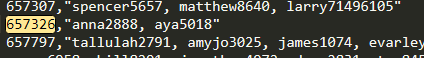

Sempre nel file loans_lenders.csv accade che per lo stesso prestito il nome di un utente venga ripetuto più volte, non è chiaro se questo è voluto.<br>
In questo caso _gmct_